In [3]:
import psycopg2
import sys
import pprint
import pandas
import random
from tableone import TableOne

In [4]:
def connect():
    "return a connection"
    conn_string = "host='localhost' dbname='mimic' user='postgres'"
    conn = psycopg2.connect(conn_string)
    return conn
    
def disconnect(conn):
    "disconnect"
    conn.commit()
    conn.close()

def get_data( query, itersize=10000):
    "return a pandas dataframe with columns names"
    conn = connect()
    cur = conn.cursor(f'tmpCursor')
    cur.itersize = itersize
    cur.execute(query)
    pd = pandas.DataFrame(cur.fetchall(),columns= [desc[0] for desc in cur.description])
    cur.close()
    disconnect(conn)
    return pd

def inStmt(col):
    "generates list"
    return ','.join(col.map(str))

In [5]:
#TEST IF JEROME CODES ARE OK
import re
f = open('infect_icd9_jab.txt')
inf = f.read()
inf = list(filter(len,re.split("\s+|\n", inf)))
inf = [x for x in inf if len(x) != 3]
#inf = list(filter(len,re.split("\s+|\n", inf)))
pred = "'),('".join(inf)
#get_data(f"WITH inf as (SELECT column1 as cd FROM (VALUES ('{pred}')) as tmp)\
#         SELECT count(1) FROM inf WHERE cd NOT IN (SELECT icd9_code FROM mimiciii.diagnoses_icd) ")
get_data(f"WITH inf as (SELECT column1 as cd FROM (VALUES ('{pred}')) as tmp)\
           SELECT count(distinct hadm_id) \
           FROM mimiciii.diagnoses_icd \
           WHERE icd9_code IN (SELECT * FROM inf)")
pred = "','".join(list(set(inf)))
a =(f"SELECT DISTINCT subject_id, hadm_id \
FROM mimiciii.diagnoses_icd \
WHERE icd9_code IN ('{pred}')")
f1=open('jero_icd9.sql', 'w+')
f1.write(a)


17072

In [6]:
# FROM ALISTAIR:
#
# - GCS should be < 13 because that's more consistent with sepsis 3 => DONE
# - You can get immature band forms from labevents as ITEMID = 51144 => OK CHAP2 INFLA
# - can you send me your pao2/fio2 analysis? Jerome and I think we should do FiO2 => THE CODE is row 146 of file angus2013.sql
# only before PaO2 - but it would be nice to really analyze the data and know all
# the details - I'd love to write up a notebook with all the details.
# - creatinine definition changed to >0.3 in 48 hours => DONE creatinine difference more than 0.3 in a 48 hour WINDOW; SAVES 2000 admissions
# - I plan to do a sensitivity analysis of the suspicion of infection definition,
# I'll try to forward you some results ASAP.


In [7]:
#ANGUS: only codes
# +  le meme jour toutes ces choses là:
# prélevement bacterio    => prelevement réalisé (liste dans sepsis 3)
# antibiotique => ()
# remplissage => (liste à définir) eau administrée
# SHOCK: DAns la fenetre 72/24, alors si vasopresseur ALORS SHOCK sinon SEVERE

#ANGUS appendix
import re
f = open('angus_appendix1.txt')
inf = f.read()
inf = list(filter(len,re.split("\s+|\n", inf)))
app1 = list()
for i in set(inf):
    if re.match(".*\d+.*,$",i):
        app1.append(i[:-1])
app1 = "|^".join(app1)
f = open('angus_appendix2.txt')
inf = f.read()
app2 = list(filter(len,re.split("\s+|\n", inf)))
app2 = "|^".join(app2)

angus = \
f'''
SELECT hadm_id 
FROM angus_deliberation
(
SELECT distinct hadm_id 
FROM mimiciii.diagnoses_icd 
WHERE icd9_code ~ '^{app1}'
INTERSECT
SELECT distinct hadm_id
FROM mimiciii.diagnoses_icd
WHERE icd9_code ~ '^{app2}'
) as tmp
'''
    
f1=open('jero_angus.sql', 'w+')
f1.write(angus)
f1.close()


In [33]:
angus = get_data('SELECT hadm_id FROM sepsis.angus_deliberation WHERE type = 1')
angus = set(angus['hadm_id']) 

In [34]:
# ACCP_SEVERE: 
# 1) dans infection icd9
# dans une fenetre de 24h :
# 2.a) 2 critères dans chap general et inflamatory
# 2.b) 1 dans Soit organ disf SOIT tissue hypo SOIT émodynamique variable
## SEPSIS TOUT COURT: 2 crit dans general et inflamatory
accp = get_data('SELECT distinct hadm_id FROM sepsis.accp_deliberation WHERE type = 2')          
accp_severe = set(accp['hadm_id'])

In [35]:
#ACCP_SIMPLE
# 1) dans infection icd9
# dans une fenetre de 24h :
# 2.) 2 critères dans chap general et inflamatory

sepsis_simple = get_data('SELECT distinct hadm_id FROM sepsis.accp_deliberation WHERE type = 1')          
accp_simple = set(sepsis_simple['hadm_id'])

In [36]:
#ACCP_SHOCK
# 1) dans infection icd9
# dans une fenetre de 24h :
# 2.) 2 critères dans chap general et inflamatory

sepsis_shock = get_data('SELECT distinct hadm_id FROM sepsis.accp_deliberation WHERE type = 3')          
accp_shock = set(sepsis_shock['hadm_id'])

In [37]:
#Sepsis3: 
# 1) dans infection icd9
# 2) sofa >= 2 
# 3) si il y a eu des vasopresseurs alors retirer ceux avec lactate >2   (car ils seraient en shock)
sofa = \
f'''
SELECT hadm_id
FROM sepsis.sepsis3_deliberation WHERE type =1
'''
sepsis3 = get_data(sofa)
sepsis3 = set(sepsis3['hadm_id'])

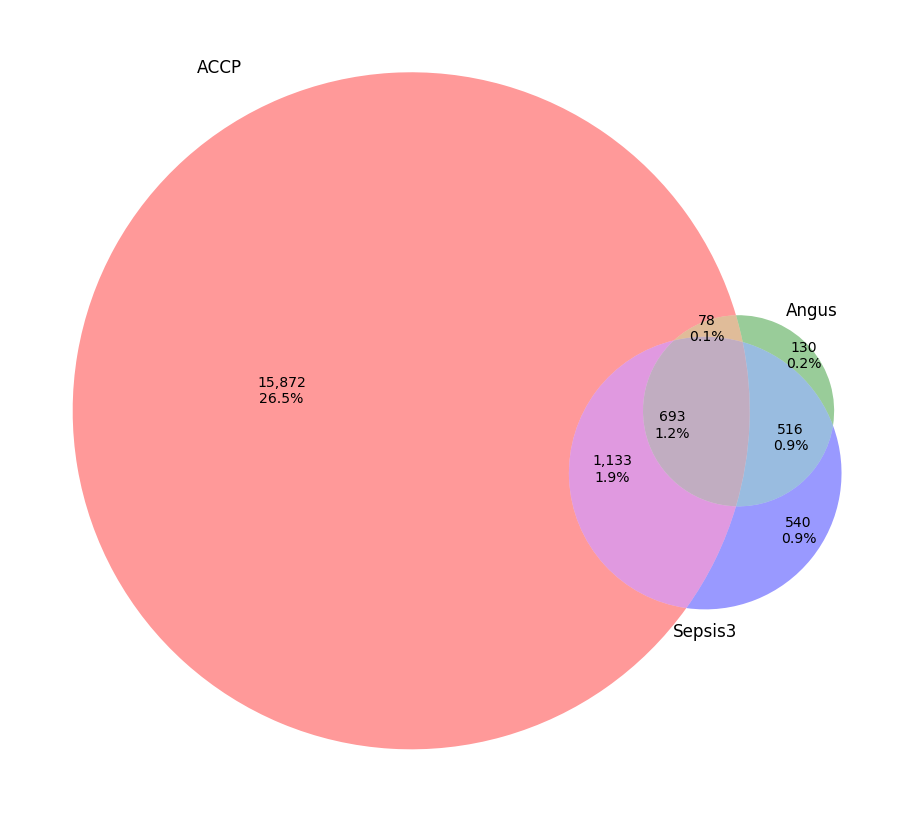

In [38]:
import pylab as plt
from matplotlib_venn import venn3
plt.figure(figsize=[16,16])
plt.rcParams.update({'font.size': 14})
venn3([accp_severe, angus, sepsis3], ('ACCP', 'Angus', 'Sepsis3'),      
subset_label_formatter=lambda x: '{:,}\n{:2.1f}%'.format(x, x*100.0/60000))
plt.savefig('sepsis3-venn.png')
plt.show()

In [31]:
#### from tableone import TableOne
data = get_data( \
f'''
SELECT 
a.hadm_id,
p.gender, 
EXTRACT(year FROM age(a.admittime, p.dob)) as age, 
EXTRACT(epoch FROM a.dischtime - a.admittime)/3600 as length_admission, 
a.hospital_expire_flag as death_admission,
ad.type as accp_type
FROM mimiciii.admissions a
LEFT JOIN mimiciii.patients p USING (subject_id)
INNER JOIN sepsis.accp_deliberation ad USING (hadm_id)
'''
)
data.index.name='id'
data.head()

strat = 'accp_type'
convars = ['age', 'length_admission']

# list of columns containing categorical variables
catvars = ['death_admission',  'gender']
strat_table = TableOne(data, convars, catvars, strat)
strat_table

Stratified by accp_type
                               1                2                3
-----------------------------  ---------------  ---------------  ---------------
n                              6152             17776            4204
age (mean (std))               6.48 (23.72)     76.02 (58.06)    78.49 (56.09)
length_admission (mean (std))  253.25 (430.18)  319.21 (318.14)  434.66 (432.79)
death_admission (n (%))
0                              6122 (99.51)     15976 (89.87)    2512 (59.75)
1                              30 (0.49)        1800 (10.13)     1692 (40.25)
gender (n (%))
F                              2784 (45.25)     8350 (46.97)     1858 (44.20)
M                              3368 (54.75)     9426 (53.03)     2346 (55.80)

In [39]:
#### from tableone import TableOne
data = get_data( \
f'''
SELECT 
a.hadm_id,
p.gender, 
EXTRACT(year FROM age(a.admittime, p.dob)) as age, 
EXTRACT(epoch FROM a.dischtime - a.admittime)/3600 as length_admission, 
a.hospital_expire_flag as death_admission,
ad.type as sepsis3_type
FROM mimiciii.admissions a
LEFT JOIN mimiciii.patients p USING (subject_id)
INNER JOIN sepsis.sepsis3_deliberation ad USING (hadm_id)
'''
)
data.index.name='id'
data.head()

strat = 'sepsis3_type'
convars = ['age', 'length_admission']

# list of columns containing categorical variables
catvars = ['death_admission',  'gender']
strat_table = TableOne(data, convars, catvars, strat)
strat_table

Stratified by sepsis3_type
                               1                2
-----------------------------  ---------------  ---------------
n                              2882             239
age (mean (std))               71.37 (54.44)    77.42 (57.84)
length_admission (mean (std))  485.23 (494.13)  393.40 (356.94)
death_admission (n (%))
0                              2312 (80.22)     196 (82.01)
1                              570 (19.78)      43 (17.99)
gender (n (%))
F                              1254 (43.51)     99 (41.42)
M                              1628 (56.49)     140 (58.58)

In [40]:
#### from tableone import TableOne
data = get_data( \
f'''
SELECT 
a.hadm_id,
p.gender, 
EXTRACT(year FROM age(a.admittime, p.dob)) as age, 
EXTRACT(epoch FROM a.dischtime - a.admittime)/3600 as length_admission, 
a.hospital_expire_flag as death_admission,
ad.type as angus_type
FROM mimiciii.admissions a
LEFT JOIN mimiciii.patients p USING (subject_id)
INNER JOIN sepsis.angus_deliberation ad USING (hadm_id)
'''
)
data.index.name='id'
data.head()

strat = 'angus_type'
convars = ['age', 'length_admission']

# list of columns containing categorical variables
catvars = ['death_admission',  'gender']
strat_table = TableOne(data, convars, catvars, strat)
strat_table

Stratified by angus_type
                               1                2
-----------------------------  ---------------  ---------------
n                              1417             53
age (mean (std))               75.71 (56.09)    71.79 (34.72)
length_admission (mean (std))  532.40 (506.05)  463.57 (369.76)
death_admission (n (%))
0                              1057 (74.59)     28 (52.83)
1                              360 (25.41)      25 (47.17)
gender (n (%))
F                              571 (40.30)      18 (33.96)
M                              846 (59.70)      35 (66.04)

In [30]:
plt.figure(figsize=[16,16])
plt.rcParams.update({'font.size': 14})
venn3([accp, sepsis_simple, sepsis_shock], ('ACCP', 'sepsis_simple', 'Sepsis Shock'),      
subset_label_formatter=lambda x: '{:,}\n{:2.1f}%'.format(x, x*100.0/60000))
plt.savefig('sepsis3-venn.png')
plt.show()

TypeError: ufunc 'bitwise_or' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [81]:
#shock

accp2 = \
f'''
WITH crit1 AS (SELECT hadm_id FROM ch0_infection_pop), 
crit2 AS (SELECT distinct hadm_id FROM ch1 ), 
crit3 AS (SELECT DISTINCT hadm_id FROM (SELECT * FROM crit1 INTERSECT SELECT * FROM crit2 ) as tmp3) 
SELECT distinct crit3.hadm_id FROM crit3 JOIN ch2 ON (crit3.hadm_id = ch2.hadm_id )
'''



set3 = set(sepsis3['hadm_id'])